In [5]:
import pickle
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['pdf.fonttype'] = 3
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

In [3]:
def read_results(result_path):
    with open(result_path, 'rb') as file:
        results = pickle.load(file)
    return results

In [7]:
def get_results(modelname, runtime, device, datasource):
    result_path = '../../projects/benchmark/results'
    result = {}
    for C in np.array([100_000, 1_000_000, 10_000_000, 20_000_000]):
        filename = f'{modelname}_{runtime}_{device}_{datasource}_C{C}_t50_results.pickle'
        f = os.path.join(result_path, filename)
        if os.path.isfile(f):
            r = read_results(f)
            result[C] = r['latency_df']
    return result

KeyError: 10000000

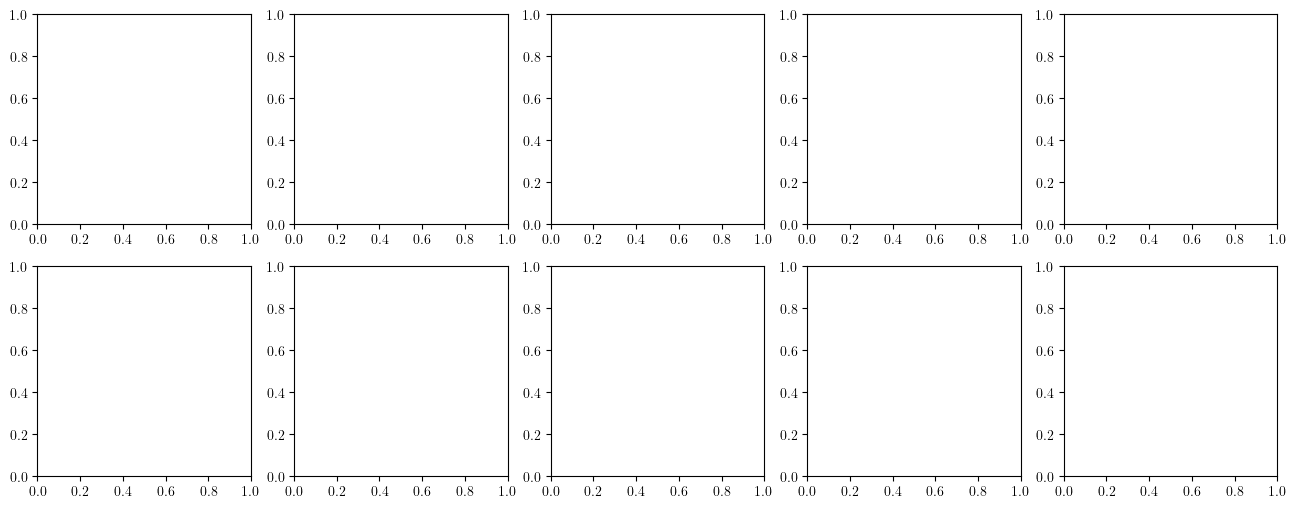

In [8]:
import matplotlib.ticker as ticker
model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'repeatnet', 'sasrec', 'sine', 'srgnn',
                        'stamp']
colors = [ 'b',  'g', 'r',  'w','c', 'm','y','k',]
markers = ['D', '+','x','D']
lss=['--','-.',':','-']

runtimes = ['eager', 'jitopt', 'onnx']
devices = ['cpu', 'cuda']
datasource = 'bolcom'

# We divide the 10 models over rows and columns
rows=2
cols=5
fig, axs = plt.subplots(rows, cols)

# start sort the models on their p90 latency on eager-CPU for C10M ASC
my_list = []
for model_name in model_names:
    results = get_results(model_name, runtime='eager', device='cpu', datasource=datasource)
    C = 10_000_000
    latency_df = results[C]
    filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
    q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
    my_list.append((model_name, q90[0]))
    
sorted_list = sorted(my_list, key=lambda x: x[1])
model_names = [item[0] for item in sorted_list]
# start sort the models on their p90 latency on eager-CPU for C10M ASC

# Loop through each subplot and create multiple plots
for i in range(rows):
    for j in range(cols):
        ax = axs[i, j]  # select the current axis
        idx = i*cols+j
        model_name = model_names[idx]
        for runtime in runtimes:
            for device in devices:
                results = get_results(model_name, runtime, device, datasource)
                if len(results) > 0:
                    q90s = []
                    cs = []
                    for C, latency_df in results.items():
                        filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
                        q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
                        q90s.append(q90)
                        cs.append(C)
                    color = colors[devices.index(device)]
                    marker = markers[runtimes.index(runtime)]
                    ls = lss[runtimes.index(runtime)]
                    ax.plot(cs, q90s, color=color, marker=marker, label=f'{runtime} {device}', linestyle=ls, alpha=0.7)    
        ax.set_title(f'Inference latency for {model_name}')
        ax.set_ylim([0.07, 1e4])
        threshold=40
        ax.axhline(y = threshold, color = 'r', label = f'{threshold}ms')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Latency (ms) p90')
        ax.set_xlabel('C')
        if idx == 0:
            ax.legend(loc=2, fontsize=10, ncol=2)
plt.tight_layout()  # adjust the spacing between subplots
# plt.savefig(f'sbr_models_{datasource}.pdf', bbox_inches='tight')
plt.show()  # display the figure